## REPORT

В этом контесте главную роль играл поиск правильных признаков. Следовательно, в отчете опишу значение каждой фичи, а также скажу, помогло ли (⭐ -- не очень, ⭐⭐⭐⭐⭐ -- очень). Там остались и лишние признаки, которые ни улучшают, ни ухудшают. Просто у меня не было времени еще и над ними думать.

Эти фичи одни дали 0.93
- ⭐⭐⭐`page_type` -- соотв. значение из webstat: строка: последняя до оформления заказа (`create_time`)
- ⭐⭐⭐`pageview_number` -- соотв. значение из webstat: строка: последняя до оформления заказа (`create_time`)
- ⭐⭐⭐⭐`pageview_duration_sec` -- соотв. значение из webstat: строка: последняя до оформления заказа (`create_time`)
- ⭐`category_id_y, model_id_y, good_id_y` -- соотв. значение из webstat: строка: последняя до оформления заказа (`create_time`)
- ⭐`price_y` -- соотв. значение из webstat: строка: последняя до оформления заказа (`create_time`)
- ⭐⭐`product_in_sale` -- соотв. значение из webstat: строка: последняя до оформления заказа (`create_time`)

Добавил другие:
- ⭐`call_after` - сколько раз зашел пользователь после оформления заказа
- ⭐⭐`go_after` - заходил ли пользователь после оформления заказа
- ⭐⭐⭐⭐`total_sec_dt, total_sec_dur, ends_nan, session_size, last_page_type, sec_diff` - из тетрадки Ильи
- ⭐⭐⭐⭐`missing_order` - есть ли пропуски в `pageview_number`. Заметил эту фичу сам, дала неплохой прирост.
- ⭐⭐⭐`visit_3, visit_6` - посещал ли пользователь вообще страницы вида 3/6?
- ⭐⭐⭐⭐⭐`before_order` - `create_time - first_time`, т.е. время на сайте до оформления заказа
- ⭐⭐⭐⭐⭐`after_order` - `last_time - create_time`, т.е. время на сайте до оформления заказа

Еще фичи на основе последней строки с сессиями до оформления:
- ⭐⭐`is_page_3, is_page_6` - совпадает ли вид страницы с 3/6?
- ⭐⭐⭐`6_more` - посетил ли пользователь больше чем 6 страниц до оформления заказа?
- ⭐⭐`first_page` - первого вида ли эта страница
- ⭐⭐`price_difference, good_difference, cat_difference, model_difference as X_difference` - `X_train` - `X_webstat`.

Еще вывод: заполнение нанов в этом задании: ошибка. Не стоит так делать.

## DATASETS

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
tr = pd.read_csv('train.csv')
tr[tr['sessionkey_id'] == 134628420]

,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter


In [ ]:
test = pd.read_csv('test.csv')
test[test['sessionkey_id'] == 133876415]

,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time
17194,1365692,1976-02-12 17:50:18,76012025,818,7,23.0,133876415,1262,1212,1183,36176829,1,NaN,NaN,762,1,1,1976-02-03 03:12:55.000
17195,1365429,1976-02-12 16:14:06,76010719,780,7,23.0,133876415,1262,1212,1183,36176829,1,NaN,NaN,762,1,1,1976-02-03 03:12:55.000


In [ ]:
web = pd.read_csv('t1_webstat.csv')
web.sort_values(['sessionkey_id', 'date_time'], inplace=True)
web.date_time = pd.to_datetime(web.date_time, errors='raise')
web.head(15)

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2268917,109996122,1975-10-17 13:42:56.953,2,1,11.0,722.0,NaN,NaN,NaN,NaN
2268918,109996122,1975-10-17 13:43:07.510,2,2,22.0,7196.0,NaN,NaN,NaN,NaN
2268919,109996122,1975-10-17 13:43:29.860,2,3,25.0,779.0,NaN,NaN,NaN,NaN
2269206,109996122,1975-10-17 13:43:54.757,2,4,9.0,7196.0,NaN,NaN,NaN,NaN
2267445,109996122,1975-10-17 13:44:03.803,2,5,11.0,723.0,NaN,NaN,NaN,NaN
2268626,109996122,1975-10-17 13:44:14.300,2,6,12.0,7418.0,NaN,NaN,NaN,NaN
2267446,109996122,1975-10-17 13:44:26.633,2,7,NaN,7419.0,NaN,NaN,NaN,NaN
2268627,110019268,1975-10-17 15:25:56.300,7,1,122.0,NaN,NaN,NaN,NaN,NaN
2268628,110019268,1975-10-17 15:27:58.257,1,2,43.0,206.0,8748965.0,22312252.0,2986.0,1.0
2269207,110019268,1975-10-17 15:28:41.860,7,3,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dates = tr.groupby('sessionkey_id', sort=False).agg(
    create_date=('create_time', lambda x: x.iloc[-1:]),
)

In [ ]:
dates2 = test.groupby('sessionkey_id', sort=False).agg(
    create_date=('create_time', lambda x: x.iloc[-1:]),
)

In [ ]:
date = pd.concat([dates, dates2])
date

,create_date
sessionkey_id,
123777004,1975-12-26 09:30:08
123781654,1975-12-26 10:58:55
123591002,1975-12-25 11:24:28
123832302,1975-12-26 14:16:06
123881603,1975-12-26 18:21:47
...,...
132569291,1976-02-04 19:10:59
131980166,1976-02-09 16:13:20
133527708,1976-02-09 14:30:59


In [ ]:
webm = web.merge(date, how='right', on='sessionkey_id', sort=False)
webm.tail(5)

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale,create_date
1461491,133876415,1976-02-12 16:11:00.700,1.0,13.0,1.0,1262.0,36489525.0,76555202.0,634.0,1.0,1976-02-12 16:14:06
1461492,133876415,1976-02-12 16:11:01.077,1.0,14.0,27.0,1262.0,35785487.0,76555204.0,570.0,1.0,1976-02-12 16:14:06
1461493,133876415,1976-02-12 16:11:28.010,3.0,15.0,18.0,NaN,NaN,NaN,NaN,NaN,1976-02-12 16:14:06
1461494,133876415,1976-02-12 16:11:46.223,4.0,16.0,89.0,NaN,NaN,NaN,NaN,NaN,1976-02-12 16:14:06
1461495,133876415,1976-02-12 16:13:15.153,3.0,17.0,7.0,NaN,NaN,NaN,NaN,NaN,1976-02-12 16:14:06


In [ ]:
from datetime import timedelta
webm.loc[webm['date_time'] > webm['create_date'], 'date_time'] -= timedelta(days=2)
webm.sort_values(['sessionkey_id', 'date_time'], inplace=True)
webm.tail(15)

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale,create_date
1342766,134626763,1976-02-16 20:48:16.223,3.0,2.0,10.0,NaN,NaN,NaN,NaN,NaN,1976-02-16 20:50:24
1316043,134627402,1976-02-16 20:50:10.233,1.0,1.0,109.0,139.0,2948574.0,44792115.0,411.0,1.0,1976-02-16 20:59:21
1316044,134627402,1976-02-16 20:51:59.770,3.0,2.0,9.0,NaN,NaN,NaN,NaN,NaN,1976-02-16 20:59:21
1316045,134627402,1976-02-16 20:53:00.973,6.0,4.0,77.0,NaN,NaN,NaN,NaN,NaN,1976-02-16 20:59:21
1316046,134627402,1976-02-16 20:54:17.023,6.0,5.0,19.0,NaN,NaN,NaN,NaN,NaN,1976-02-16 20:59:21
1316047,134627402,1976-02-16 20:54:36.927,6.0,6.0,29.0,NaN,NaN,NaN,NaN,NaN,1976-02-16 20:59:21
1316048,134627402,1976-02-16 20:55:05.017,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,1976-02-16 20:59:21
1316049,134627402,1976-02-16 20:55:09.017,3.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,1976-02-16 20:59:21
1335374,134628420,1976-02-14 20:59:14.477,2.0,8.0,NaN,1504.0,NaN,NaN,NaN,NaN,1976-02-16 20:58:39
1335370,134628420,1976-02-16 20:54:40.853,1.0,1.0,34.0,8018.0,5771138.0,NaN,NaN,NaN,1976-02-16 20:58:39


## CLOSER LOOK

In [ ]:
# изучаем разные сессии... думаем, что бы еще такое намутить... отчего же может зависеть "звонок"..? что интересного перед нами..? 0_0
pd.options.display.max_rows = 100
web.query('sessionkey_id == 111547831')
# NOOOOOOOOOOOOO

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2320883,111547831,1975-10-25 14:22:45.900,2,1,22.0,1259.0,NaN,NaN,NaN,NaN
2320884,111547831,1975-10-25 14:23:07.620,1,2,50.0,1259.0,22116857.0,41668224.0,5701.0,1.0
2320127,111547831,1975-10-25 14:23:57.237,2,3,55.0,1259.0,NaN,NaN,NaN,NaN
2320885,111547831,1975-10-25 14:24:52.663,1,4,67.0,1259.0,12019050.0,27548428.0,761.0,1.0
2320886,111547831,1975-10-25 14:25:59.237,2,5,49.0,1259.0,NaN,NaN,NaN,NaN
2292987,111547831,1975-10-25 14:26:48.630,1,6,27.0,1259.0,135962.0,56955353.0,1522.0,1.0
2320887,111547831,1975-10-25 14:27:15.930,2,7,31.0,1259.0,NaN,NaN,NaN,NaN
2292239,111547831,1975-10-25 14:27:46.723,1,8,55.0,1259.0,1531812.0,32061927.0,904.0,1.0
2320128,111547831,1975-10-25 14:28:41.073,2,9,16.0,1259.0,NaN,NaN,NaN,NaN
2292240,111547831,1975-10-25 14:28:57.857,1,10,NaN,1259.0,3083590.0,64787126.0,1102.0,1.0


In [ ]:
# изучаем разные сессии... думаем, что бы еще такое намутить... отчего же может зависеть "звонок"..? что интересного перед нами..? 0_0
pd.options.display.max_rows = 100
web.query('sessionkey_id == 130923316')
# NOOOOOOOOOOOO

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
1680664,130923316,1976-01-28 09:31:59.860,1,1,104.0,2846.0,12073601.0,42057289.0,2903.0,1.0
1712100,130923316,1976-01-28 09:33:43.560,1,2,255.0,2846.0,17044323.0,28953379.0,2561.0,1.0
1583731,130923316,1976-01-28 09:37:58.830,1,3,110.0,2846.0,17044323.0,28953379.0,2561.0,1.0
2157879,130923316,1976-01-28 09:39:48.153,3,4,23.0,NaN,NaN,NaN,NaN,NaN
1680665,130923316,1976-01-28 09:43:04.650,2,6,52.0,3358.0,NaN,NaN,NaN,NaN
1680666,130923316,1976-01-28 09:43:56.137,7,7,9.0,NaN,NaN,NaN,NaN,NaN
1680667,130923316,1976-01-28 09:44:05.450,2,8,2.0,3358.0,NaN,NaN,NaN,NaN
1712101,130923316,1976-01-28 09:44:16.817,9,10,1527.0,NaN,NaN,NaN,NaN,NaN
1680668,130923316,1976-01-28 10:09:43.597,3,11,41.0,NaN,NaN,NaN,NaN,NaN
2157880,130923316,1976-01-28 10:33:57.267,1,15,13.0,2846.0,12073601.0,42057289.0,2903.0,1.0


In [ ]:
# изучаем разные сессии... думаем, что бы еще такое намутить... отчего же может зависеть "звонок"..? что интересного перед нами..? 0_0
pd.options.display.max_rows = 100
web.query('sessionkey_id == 123777004')
# YEEEEEESSSSSSSSS

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
644278,123777004,1975-12-26 09:21:03.393,1,1,NaN,139.0,123517.0,9896348.0,753.0,1.0


In [ ]:
# изучаем разные сессии... думаем, что бы еще такое намутить... отчего же может зависеть "звонок"..? что интересного перед нами..? 0_0
pd.options.display.max_rows = 100
web.query('sessionkey_id == 123832302')
# YEEEEESSSSSS

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
671447,123832302,1975-12-26 13:57:51.157,2,1,109.0,139.0,NaN,NaN,NaN,NaN
671448,123832302,1975-12-26 13:59:40.117,2,2,352.0,1525.0,NaN,NaN,NaN,NaN
671449,123832302,1975-12-26 14:05:32.600,2,3,25.0,1525.0,NaN,NaN,NaN,NaN
779981,123832302,1975-12-26 14:05:57.430,2,4,1402.0,139.0,NaN,NaN,NaN,NaN
779982,123832302,1975-12-26 14:29:19.873,2,5,38.0,133.0,NaN,NaN,NaN,NaN
779983,123832302,1975-12-26 14:29:57.153,2,6,NaN,1525.0,NaN,NaN,NaN,NaN


In [ ]:
# изучаем разные сессии... думаем, что бы еще такое намутить... отчего же может зависеть "звонок"..? что интересного перед нами..? 0_0
pd.options.display.max_rows = 100
web.query('sessionkey_id == 119586855')
# NOOOOOOOOO

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
117772,119586855,1975-12-05 09:12:02.313,1,1,118.0,1329.0,6155675.0,67964881.0,53822.0,1.0
61639,119586855,1975-12-05 09:14:00.343,4,2,58.0,NaN,NaN,NaN,NaN,NaN
151610,119586855,1975-12-05 09:14:58.863,2,3,25.0,255.0,NaN,NaN,NaN,NaN
61640,119586855,1975-12-05 09:15:23.193,5,4,29.0,NaN,NaN,NaN,NaN,NaN
61641,119586855,1975-12-05 09:15:52.813,2,5,4.0,255.0,NaN,NaN,NaN,NaN
151611,119586855,1975-12-05 09:15:56.503,4,6,5.0,NaN,NaN,NaN,NaN,NaN
61642,119586855,1975-12-05 09:16:01.127,1,7,4.0,1329.0,6155675.0,67964881.0,53822.0,1.0
151612,119586855,1975-12-05 09:16:05.627,3,8,29.0,NaN,NaN,NaN,NaN,NaN
61643,119586855,1975-12-05 09:16:52.237,3,10,12.0,NaN,NaN,NaN,NaN,NaN
152755,119586855,1975-12-05 09:26:23.563,6,15,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# изучаем разные сессии... думаем, что бы еще такое намутить... отчего же может зависеть "звонок"..? что интересного перед нами..? 0_0
pd.options.display.max_rows = 100
web.query('sessionkey_id == 124279932')
# NOOOOOOOOO

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
795573,124279932,1975-12-29 10:58:20.647,1,1,21.0,1486.0,28099411.0,61052440.0,56949.0,1.0
829703,124279932,1975-12-29 10:58:41.120,3,2,8.0,NaN,NaN,NaN,NaN,NaN
795930,124279932,1975-12-29 10:59:05.593,3,4,4.0,NaN,NaN,NaN,NaN,NaN
829704,124279932,1975-12-29 11:06:31.627,6,6,13.0,NaN,NaN,NaN,NaN,NaN
707989,124279932,1975-12-29 11:06:44.657,6,7,9.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# изучаем разные сессии... думаем, что бы еще такое намутить... отчего же может зависеть "звонок"..? что интересного перед нами..? 0_0
pd.options.display.max_rows = 100
web.query('sessionkey_id == 113171461')
# YEEEEEESSSSSSSSS

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2389145,113171461,1975-11-02 11:01:59.357,1,1,NaN,6776.0,28935075.0,NaN,NaN,NaN


In [ ]:
# изучаем разные сессии... думаем, что бы еще такое намутить... отчего же может зависеть "звонок"..? что интересного перед нами..? 0_0
pd.options.display.max_rows = 100
web.query('sessionkey_id == 128581281')
# YEEEEESSSSSSSSSSS

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
1420046,128581281,1976-01-19 10:54:24.590,2,1,30.0,207.0,NaN,NaN,NaN,NaN
1419934,128581281,1976-01-19 10:54:54.763,2,2,38.0,207.0,NaN,NaN,NaN,NaN
1420047,128581281,1976-01-19 10:55:32.137,1,3,58.0,207.0,1510460.0,37329259.0,53287.0,1.0
1465775,128581281,1976-01-19 10:56:30.900,1,4,103.0,207.0,1510517.0,72339013.0,53928.0,1.0
1339653,128581281,1976-01-19 10:58:13.483,1,5,NaN,207.0,1510578.0,37329264.0,62930.0,1.0


In [ ]:
# изучаем разные сессии... думаем, что бы еще такое намутить... отчего же может зависеть "звонок"..? что интересного перед нами..? 0_0
pd.options.display.max_rows = 100
web.query('sessionkey_id == 131679312')
# NOOOOOOOOOOO

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
1808620,131679312,1976-01-31 17:18:43.380,8,1,10.0,NaN,NaN,NaN,NaN,NaN
2177030,131679312,1976-01-31 17:18:53.467,2,2,31.0,155.0,NaN,NaN,NaN,NaN
1808621,131679312,1976-01-31 17:19:24.657,5,3,35.0,NaN,NaN,NaN,NaN,NaN
1835830,131679312,1976-01-31 17:19:59.320,5,4,21.0,NaN,NaN,NaN,NaN,NaN
1808622,131679312,1976-01-31 17:20:20.967,5,5,84.0,NaN,NaN,NaN,NaN,NaN
1697358,131679312,1976-01-31 17:21:44.720,5,6,25.0,NaN,NaN,NaN,NaN,NaN
1808623,131679312,1976-01-31 17:22:09.317,2,7,9.0,155.0,NaN,NaN,NaN,NaN
1697359,131679312,1976-01-31 17:22:18.130,1,8,483.0,155.0,32551595.0,73666398.0,2013.0,1.0
1808624,131679312,1976-01-31 17:30:21.743,2,9,10.0,155.0,NaN,NaN,NaN,NaN
1697360,131679312,1976-01-31 17:30:31.453,1,10,253.0,155.0,31474319.0,75358109.0,1768.0,1.0


In [ ]:
# изучаем разные сессии... думаем, что бы еще такое намутить... отчего же может зависеть "звонок"..? что интересного перед нами..? 0_0
pd.options.display.max_rows = 100
web.query('sessionkey_id == 131627901')
# YEEEEEEEEESSSSSSSSSS

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2169148,131627901,1976-01-31 12:30:30.670,1,1,57.0,155.0,26673811.0,68282467.0,5631.0,1.0
1813964,131627901,1976-01-31 12:31:27.683,4,2,38.0,NaN,NaN,NaN,NaN,NaN
2169149,131627901,1976-01-31 12:32:05.757,1,3,NaN,155.0,26673811.0,68282467.0,5631.0,1.0


In [ ]:
pd.options.display.max_rows = 100
web.query('sessionkey_id == 131633131')
# YEEEEEEEEESSSSSSSSSS

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
1770974,131633131,1976-01-31 13:01:39.400,2,1,24.0,1525.0,NaN,NaN,NaN,NaN
2170225,131633131,1976-01-31 13:02:03.143,1,2,29.0,1525.0,14956407.0,73302965.0,1236.0,1.0
1678979,131633131,1976-01-31 13:02:32.717,2,3,23.0,1525.0,NaN,NaN,NaN,NaN
1816646,131633131,1976-01-31 13:02:55.190,1,4,83.0,1525.0,12009886.0,44840768.0,545.0,1.0
1678980,131633131,1976-01-31 13:04:18.533,2,5,12.0,1525.0,NaN,NaN,NaN,NaN
1816647,131633131,1976-01-31 13:04:30.117,1,6,158.0,1525.0,8236130.0,44840735.0,892.0,1.0
1678981,131633131,1976-01-31 13:07:08.127,2,7,10.0,1525.0,NaN,NaN,NaN,NaN
2170226,131633131,1976-01-31 13:07:18.347,1,8,77.0,1525.0,4280797.0,74284755.0,796.0,1.0
2170227,131633131,1976-01-31 13:08:35.817,3,9,17.0,NaN,NaN,NaN,NaN,NaN
1770975,131633131,1976-01-31 13:10:33.140,3,11,3.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
pd.options.display.max_rows = 100
web.query('sessionkey_id == 125624354')
# YEEEEEEEEESSSSSSSSSS

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
1020191,125624354,1976-01-05 15:28:56.790,2,1,206.0,181.0,NaN,NaN,NaN,NaN
1064623,125624354,1976-01-05 15:32:22.697,2,2,54.0,181.0,NaN,NaN,NaN,NaN
1064624,125624354,1976-01-05 15:33:16.510,1,3,581.0,181.0,25300568.0,53134235.0,4290.0,1.0
1020192,125624354,1976-01-05 15:42:57.853,2,4,17.0,127.0,NaN,NaN,NaN,NaN
1020193,125624354,1976-01-05 15:43:14.963,1,5,32.0,127.0,1950458.0,60545602.0,3691.0,1.0
923456,125624354,1976-01-05 15:43:46.070,1,6,16.0,127.0,8961504.0,32160427.0,2627.0,1.0
1064625,125624354,1976-01-05 15:44:02.603,1,7,41.0,127.0,1594348.0,58892833.0,3541.0,1.0
1064626,125624354,1976-01-05 15:44:43.530,1,8,60.0,127.0,2562152.0,62771512.0,3220.0,1.0
1013739,125624354,1976-01-05 15:45:43.487,1,9,20.0,127.0,1692403.0,34642817.0,3287.0,1.0
923457,125624354,1976-01-05 15:46:03.993,1,10,18.0,127.0,9084868.0,34382395.0,2723.0,1.0


In [ ]:
pd.options.display.max_rows = 100
web.query('sessionkey_id == 128592168')
# NOOOOOOOOOOOOOOOOOOOOO

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
1471977,128592168,1976-01-19 11:32:15.443,2,1,36.0,181.0,NaN,NaN,NaN,NaN
1323694,128592168,1976-01-19 11:32:51.333,1,2,47.0,181.0,1656449.0,44857411.0,2545.0,1.0
1323695,128592168,1976-01-19 11:33:38.617,3,3,17.0,NaN,NaN,NaN,NaN,NaN
1428294,128592168,1976-01-19 11:33:55.173,1,4,4.0,181.0,1656449.0,44857411.0,2545.0,1.0
1323696,128592168,1976-01-19 11:33:59.530,3,5,4.0,NaN,NaN,NaN,NaN,NaN
1425875,128592168,1976-01-19 11:34:03.770,1,6,15.0,181.0,1656449.0,44857411.0,2545.0,1.0
1323697,128592168,1976-01-19 11:34:18.073,2,7,17.0,181.0,NaN,NaN,NaN,NaN
1428295,128592168,1976-01-19 11:34:35.613,2,8,111.0,181.0,NaN,NaN,NaN,NaN
1428296,128592168,1976-01-19 11:36:26.693,3,9,4.0,NaN,NaN,NaN,NaN,NaN
1425876,128592168,1976-01-19 11:38:33.820,6,11,38.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
pd.options.display.max_rows = 100
web.query('sessionkey_id == 131497124')
# NOOOOOOOOOOOOOOOOOOOOO

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
1671901,131497124,1976-01-30 17:35:13.463,2,1,67.0,201.0,NaN,NaN,NaN,NaN
1671902,131497124,1976-01-30 17:36:20.160,2,2,1737.0,217.0,NaN,NaN,NaN,NaN
1671994,131497124,1976-01-30 18:05:17.987,3,3,60.0,NaN,NaN,NaN,NaN,NaN
1796976,131497124,1976-01-30 18:23:39.587,6,6,212.0,NaN,NaN,NaN,NaN,NaN
1671995,131497124,1976-01-30 18:27:11.460,10,7,19.0,NaN,NaN,NaN,NaN,NaN
1796977,131497124,1976-01-30 18:27:30.200,2,8,253.0,2617.0,NaN,NaN,NaN,NaN
1671996,131497124,1976-01-30 18:31:43.030,10,9,115.0,NaN,NaN,NaN,NaN,NaN
1758380,131497124,1976-01-30 18:33:38.507,2,10,33.0,6837.0,NaN,NaN,NaN,NaN
1671997,131497124,1976-01-30 18:34:11.533,2,11,337.0,6026.0,NaN,NaN,NaN,NaN
1671998,131497124,1976-01-30 18:39:48.597,7,12,16.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
pd.options.display.max_rows = 100
web.query('sessionkey_id == 114314272')
# YEEEEEEEEESSSSSSSSSS

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2590927,114314272,1975-11-08 11:31:34.963,1,1,NaN,6026.0,27625827.0,60268954.0,955.0,1.0


In [ ]:
pd.options.display.max_rows = 100
web.query('sessionkey_id == 115019749')
# NOOOOOOOOOOOOOOOOOOO

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2712129,115019749,1975-11-12 13:54:40.860,1,1,16.0,6029.0,25552657.0,55628788.0,127.0,1.0
2715193,115019749,1975-11-12 13:54:56.193,1,2,44.0,6029.0,25552657.0,55628788.0,127.0,1.0
2712130,115019749,1975-11-12 13:55:40.563,3,3,15.0,NaN,NaN,NaN,NaN,NaN
2655252,115019749,1975-11-12 14:03:19.273,6,7,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
tr[tr['is_callcenter'] == 1]['utm_source'].isna().sum()/tr['utm_source'].isna().sum()

0.2817224880382775

In [ ]:

set(test['sessionkey_id']).intersection(set(tr['sessionkey_id']))

{130923316,
 131050586,
 131053383,
 131193399,
 131197175,
 131350178,
 131472486,
 131478990,
 131480926,
 131499083,
 131501278,
 131610437,
 131712641}

## FEATURE GEN.

In [ ]:
# собираем агрегаты

session_agg = webm.groupby('sessionkey_id', sort=False).agg(
    last_before=('date_time', lambda x: x[-1:]),
    page_type=('page_type', lambda x: x.iloc[-1:]),
    pageview_number=('pageview_number', lambda x: x.iloc[-1:]),
    pageview_duration_sec=('pageview_duration_sec', lambda x: x.iloc[-1:]),
    category_id=('category_id', lambda x: x.iloc[-1:]),
    model_id=('model_id', lambda x: x.iloc[-1:]),
    good_id=('good_id', lambda x: x.iloc[-1:]),
    price=('price', lambda x: x.iloc[-1:]),
    product_in_sale=('product_in_sale', lambda x: x.iloc[-1:]),
    call_after=('date_time', lambda x: x.isna().sum())
)


In [ ]:
session_agg

,last_before,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale,call_after
sessionkey_id,,,,,,,,,,
111130742,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
111514516,1975-10-25 10:06:19.437,3.0,2.0,11.0,NaN,NaN,NaN,NaN,NaN,0
111533963,1975-10-25 12:43:17.797,1.0,2.0,NaN,2382.0,5061075.0,65207827.0,2866.0,1.0,0
111547831,1975-10-25 14:28:57.857,1.0,10.0,NaN,1259.0,3083590.0,64787126.0,1102.0,1.0,0
111591525,1975-10-25 19:46:10.950,4.0,10.0,NaN,1342.0,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
134626613,1976-02-16 20:47:56.087,1.0,5.0,525.0,4758.0,31422709.0,NaN,NaN,NaN,0
134626763,1976-02-16 20:48:16.223,3.0,2.0,10.0,NaN,NaN,NaN,NaN,NaN,0
134627402,1976-02-16 20:55:09.017,3.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
another_ses = web.groupby('sessionkey_id', sort=False).agg(
    last_timestamp=('date_time', lambda x: x.iloc[-1]),
    total_sec_dt=('date_time', lambda x: (x.iloc[-1] - x.iloc[0])), # 1
    total_sec_dur=('pageview_duration_sec', lambda x: np.nansum(x)), # 2
    ends_nan=('pageview_duration_sec', lambda x: int(pd.isna(x.iloc[-1]))), # 3
    last_page_type=('page_type', lambda x: x.iloc[-1]), # 4
    session_size=('page_type', lambda x: x.shape[0]), 
    missing_order=('pageview_number', lambda x: np.nansum(x) != x.shape[0] * (x.shape[0] + 1) / 2), # 5. est' li propuski v porqdke
    visit_3=('page_type', lambda x: np.count_nonzero(x == 3) > 0),
    visit_6=('page_type', lambda x: np.count_nonzero(x == 6) > 0)
    
)

In [ ]:
another_ses

,last_timestamp,total_sec_dt,total_sec_dur,ends_nan,last_page_type,session_size,missing_order,visit_3,visit_6
sessionkey_id,,,,,,,,,
109996122,1975-10-17 13:44:26.633,0 days 00:01:29.680000,90.0,1,2,7,False,False,False
110019268,1975-10-17 15:28:41.860,0 days 00:02:45.560000,165.0,1,7,3,False,False,False
110020180,1975-10-17 15:29:52.147,0 days 00:00:00,0.0,1,1,1,False,False,False
110040418,1975-10-17 17:15:33.020,0 days 00:09:51.490000,545.0,1,2,11,True,True,False
110044482,1975-10-17 17:27:55.297,0 days 00:00:00,0.0,1,1,1,False,False,False
...,...,...,...,...,...,...,...,...,...
134626779,1976-02-16 20:47:13.283,0 days 00:00:00,22.0,0,3,1,False,True,False
134627402,1976-02-16 20:55:09.017,0 days 00:04:58.784000,244.0,1,3,7,True,True,True
134628420,1976-02-16 20:59:14.477,0 days 00:04:33.624000,93.0,1,2,5,True,True,False


In [ ]:
another_ses['total_sec_dt'] = another_ses['total_sec_dt'].astype('timedelta64[s]') # теперь ок
another_ses['sec_diff'] = another_ses['total_sec_dt'] - another_ses['total_sec_dur'] # фича номер 6. зачем? дальш

In [ ]:
session_agg['go_after'] = 0
session_agg.loc[session_agg['call_after'] > 0, 'go_after'] = 1

In [ ]:
# джойнить так
tr_merg = tr.merge(session_agg, how='left', on='sessionkey_id', sort=False)
tr_merge = tr_merg.merge(another_ses, how='left', on='sessionkey_id', sort=False)
tr_merge.tail(3)

,order_id,create_time,good_id_x,price_x,utm_medium,utm_source,sessionkey_id,category_id_x,parent_id,root_id,...,last_timestamp,total_sec_dt,total_sec_dur,ends_nan,last_page_type,session_size,missing_order,visit_3,visit_6,sec_diff
104592,1180920,1975-11-12 09:14:35,66971400,1452,2,NaN,114972131,2873,1229,1183,...,1975-11-12 09:15:26.047,2275.0,1602.0,0.0,6.0,39.0,True,True,True,673.0
104593,1177882,1975-11-10 17:28:07,60391498,1433,4,2.0,114672813,2873,1229,1183,...,1975-11-10 17:23:02.973,1361.0,1361.0,1.0,1.0,9.0,False,False,False,0.0
104594,1197777,1975-11-20 10:35:19,65302780,56,6,7.0,116314003,2873,1229,1183,...,1975-11-19 14:49:35.277,296.0,223.0,1.0,6.0,15.0,True,True,True,73.0


In [ ]:
# джойнить так
test_merg = test.merge(session_agg, how='left', on='sessionkey_id', sort=False)
test_merge = test_merg.merge(another_ses, how='left', on='sessionkey_id', sort=False)
test_merge.tail(5)

,order_id,create_time,good_id_x,price_x,utm_medium,utm_source,sessionkey_id,category_id_x,parent_id,root_id,...,last_timestamp,total_sec_dt,total_sec_dur,ends_nan,last_page_type,session_size,missing_order,visit_3,visit_6,sec_diff
17191,1358397,1976-02-09 16:13:20,74484779,236,1,2.0,131980166,242,2113,1795,...,1976-02-02 09:02:14.140,0.0,0.0,1.0,2.0,1.0,False,False,False,0.0
17192,1357968,1976-02-09 14:30:59,75277186,108,4,2.0,133527708,142,140,124,...,1976-02-09 14:26:24.480,147.0,206.0,0.0,3.0,3.0,False,True,False,-59.0
17193,1358835,1976-02-09 18:39:45,75382827,602,1,1.0,133585500,810,7876,722,...,1976-02-09 18:30:36.407,91.0,91.0,1.0,9.0,3.0,False,False,False,0.0
17194,1365692,1976-02-12 17:50:18,76012025,818,7,23.0,133876415,1262,1212,1183,...,1976-02-12 16:13:15.153,271.0,278.0,0.0,3.0,17.0,False,True,False,-7.0
17195,1365429,1976-02-12 16:14:06,76010719,780,7,23.0,133876415,1262,1212,1183,...,1976-02-12 16:13:15.153,271.0,278.0,0.0,3.0,17.0,False,True,False,-7.0


## VISUALIZATION

product_in_sale бывает 1.0 только если последняя страница типа 1.0. 
Иначе сказать ничего не можем. Фича бесполезная. Дропнуть

In [ ]:
# Analogichno s price. 

In [ ]:
len(tr_merge[(tr_merge['product_in_sale'] == 1.0) & (tr_merge['page_type'] != 1.0)])

In [ ]:
len(tr_merge[(tr_merge['page_type'] == 1.0) & (tr_merge['is_callcenter'] == 0)])/len(tr_merge[(tr_merge['page_type'] == 1.0)])

In [ ]:
len(tr_merge[(tr_merge['page_type'] != 1.0) & (tr_merge['is_callcenter'] == 1)])/len(tr_merge[(tr_merge['page_type'] != 1.0)])

In [ ]:
len(tr_merge[(tr_merge['page_type'] != 1.0) & (tr_merge['is_callcenter'] == 0)])/len(tr_merge[(tr_merge['page_type'] != 1.0)])

<Axes: xlabel='page_type', ylabel='pageview_duration_sec'>

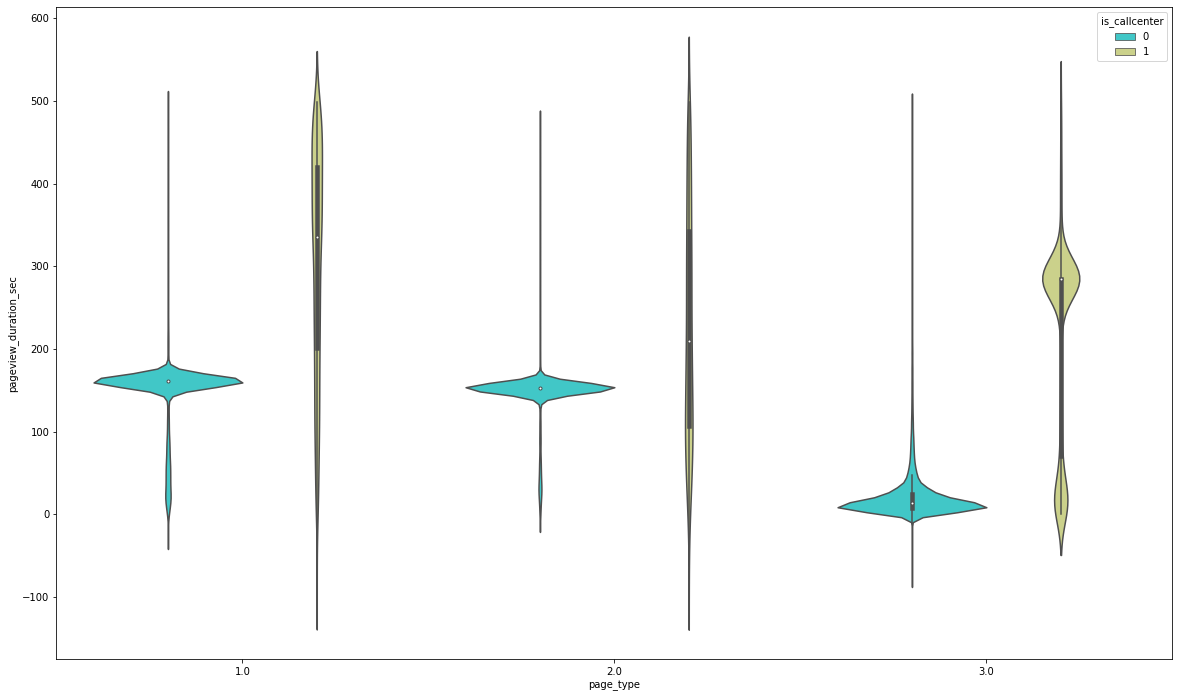

In [ ]:
plt.figure(figsize=(20,12))
sns.violinplot(x='page_type', y="pageview_duration_sec",data=tr_merge[(tr_merge['page_type'] < 4) & (tr_merge['pageview_duration_sec'] < 500.0) & (tr_merge['pageview_duration_sec'] > -100.0)], hue='is_callcenter', palette='rainbow')

In [ ]:
test_merge['pageview_duration_sec'].isna().sum()/test_merge['pageview_duration_sec'].shape[0]

0.3888695045359386

Text(0.5, 1.0, 'Count of page_type, Separated by is_callcenter')

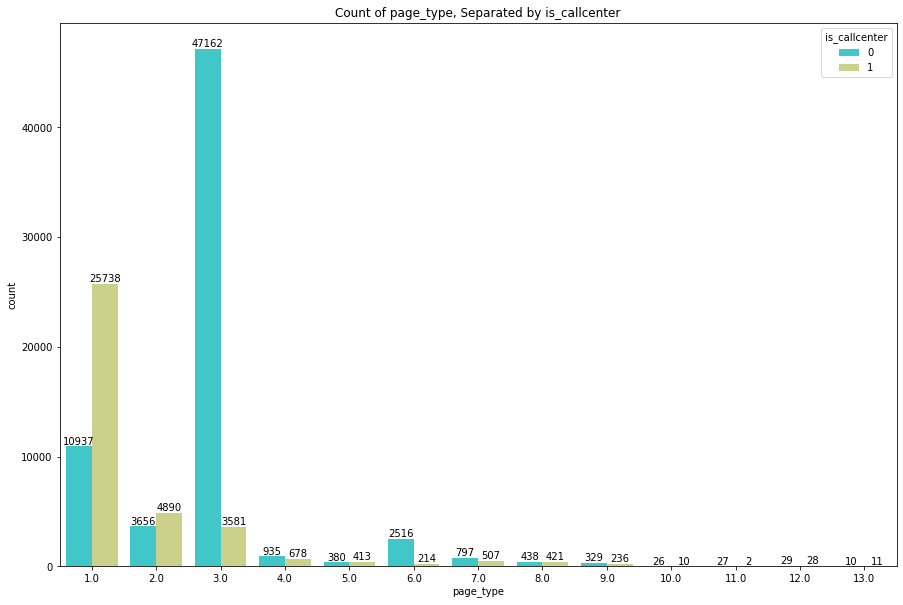

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x='page_type',data=tr_merge, palette='rainbow',hue='is_callcenter')
for container in ax.containers:
    ax.bar_label(container)
plt.title("Count of page_type, Separated by is_callcenter")

SLISHKOM RAVNOVEROYATNO VSE. DROPNUT' PRICE_Y

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x='pageview_number',data=tr_merge[(tr_merge['pageview_number'] > 30.0) & (tr_merge['pageview_number'] < 55.0)], palette='rainbow',hue='is_callcenter')
for container in ax.containers:
    ax.bar_label(container)
plt.title("Count of page_type, Separated by is_callcenter")
# pageview_number

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x='pageview_number',data=tr_merge[(tr_merge['pageview_number'] > 30.0) & (tr_merge['pageview_number'] < 55.0)], palette='rainbow',hue='is_callcenter')
for container in ax.containers:
    ax.bar_label(container)
plt.title("Count of page_type, Separated by is_callcenter")

In [ ]:
len(tr_merge[(tr_merge['price_difference'] < 00.0) & (tr_merge['is_callcenter'] == 1)])/len(tr_merge[(tr_merge['price_difference'] < 00.0)])

In [ ]:
# ne stoit smotret' na raznicu prices

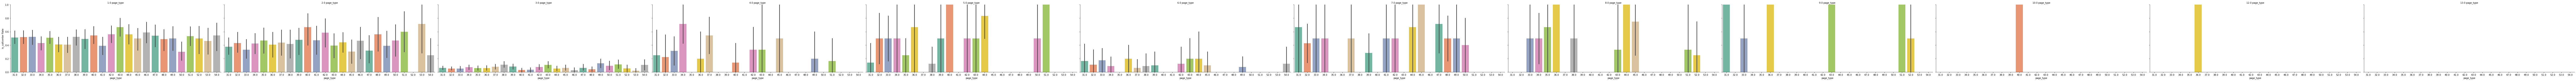

In [ ]:
g = sns.catplot(x='pageview_number',y='is_callcenter', col = 'page_type', data=tr_merge[(tr_merge['pageview_number'] > 30.0) & (tr_merge['pageview_number'] < 55.0)],
                kind='bar', aspect=2.6, palette='Set2')
(g.set_axis_labels("page_type", "is_callcenter Rate")
  .set_titles("{col_name} page_type")
  .set(ylim=(0,1)))
plt.tight_layout()

---

---

---

---

---

Text(0.5, 1.0, 'Count of page_type, Separated by is_callcenter')

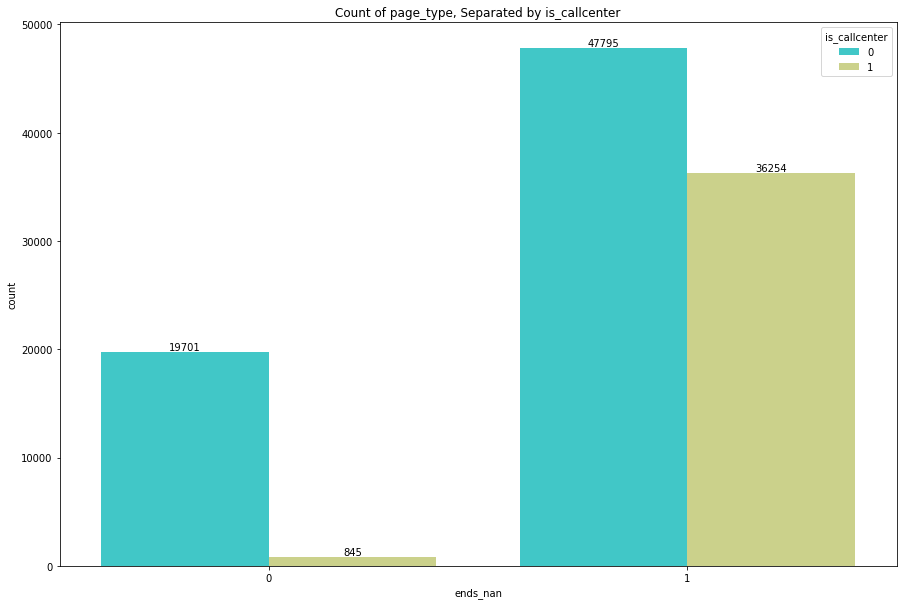

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x='ends_nan',data=tr_merge, palette='rainbow',hue='is_callcenter')
for container in ax.containers:
    ax.bar_label(container)
plt.title("Count of page_type, Separated by is_callcenter")

## MORE FEATURES

In [ ]:
tr_merge[['create_time', 'last_timestamp', 'last_before']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104595 entries, 0 to 104594
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   create_time     104595 non-null  object        
 1   last_timestamp  103971 non-null  datetime64[ns]
 2   last_before     103971 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 3.2+ MB


In [ ]:
tr_merge['create_time'] = pd.to_datetime(tr_merge['create_time'])
test_merge['create_time'] = pd.to_datetime(test_merge['create_time'])

In [ ]:
tr_merge['before_order'] = (tr_merge['create_time'] - tr_merge['last_before']).astype('timedelta64[s]')
test_merge['before_order'] = (test_merge['create_time'] - test_merge['last_before']).astype('timedelta64[s]')

tr_merge['after_order'] = (tr_merge['last_timestamp'] - tr_merge['create_time']).astype('timedelta64[s]')
test_merge['after_order'] = (test_merge['last_timestamp'] - test_merge['create_time']).astype('timedelta64[s]')

In [ ]:
tr_merge['product_in_sale'] = tr_merge['product_in_sale'].fillna(0)
test_merge['product_in_sale'] = test_merge['product_in_sale'].fillna(0)

In [ ]:
tr_merge['create_time'] = tr_merge['create_time'].astype('datetime64').astype(int).astype(float)
tr_merge['model_create_time'] = tr_merge['model_create_time'].astype('datetime64').astype(int).astype(float)
test_merge['create_time'] = test_merge['create_time'].astype('datetime64').astype(int).astype(float)
test_merge['model_create_time'] = test_merge['model_create_time'].astype('datetime64').astype(int).astype(float)
tr_merge['product_in_sale'] = tr_merge['product_in_sale'].fillna(0)
test_merge['product_in_sale'] = test_merge['product_in_sale'].fillna(0)

In [ ]:
tr_merge['is_page_3'] = tr_merge['page_type'].map(lambda x: x == 3.0)
tr_merge['is_page_6'] = tr_merge['page_type'].map(lambda x: x == 6.0)
tr_merge['6_more'] = tr_merge['pageview_number'].map(lambda x: x > 5.0)
tr_merge['first_page'] = tr_merge['pageview_number'].map(lambda x: x == 1.0)
tr_merge['price_difference'] = tr_merge['price_x'] - tr_merge['price_y']
tr_merge['good_difference'] = tr_merge['good_id_x'] - tr_merge['good_id_y']
tr_merge['cat_difference'] = tr_merge['category_id_x'] - tr_merge['category_id_y']
tr_merge['model_difference'] = tr_merge['model_id_x'] - tr_merge['model_id_y']

test_merge['is_page_3'] = test_merge['page_type'].map(lambda x: x == 3.0)
test_merge['is_page_6'] = test_merge['page_type'].map(lambda x: x == 6.0)
test_merge['6_more'] = test_merge['pageview_number'].map(lambda x: x > 5.0)
test_merge['first_page'] = test_merge['pageview_number'].map(lambda x: x == 1.0)
test_merge['price_difference'] = test_merge['price_x'] - test_merge['price_y']
test_merge['good_difference'] = test_merge['good_id_x'] - test_merge['good_id_y']
test_merge['cat_difference'] = test_merge['category_id_x'] - test_merge['category_id_y']
test_merge['model_difference'] = test_merge['model_id_x'] - test_merge['model_id_y']

In [ ]:
tr_merge['missing_order'] = tr_merge['missing_order'].fillna(False)
test_merge['missing_order'] = test_merge['missing_order'].fillna(False)
tr_merge['missing_order'] = tr_merge['missing_order'].astype(int)
test_merge['missing_order'] = test_merge['missing_order'].astype(int)

tr_merge['ends_nan'] = tr_merge['ends_nan'].fillna(True)
test_merge['ends_nan'] = test_merge['ends_nan'].fillna(True)
tr_merge['ends_nan'] = tr_merge['ends_nan'].astype(int)
test_merge['ends_nan'] = test_merge['ends_nan'].astype(int)

In [ ]:
tr_merge['price_difference'] = tr_merge['price_difference'].fillna(0)
tr_merge['good_difference'] = tr_merge['good_difference'].fillna(0)
tr_merge['cat_difference'] = tr_merge['cat_difference'].fillna(0)
tr_merge['model_difference'] = tr_merge['model_difference'].fillna(0)

test_merge['price_difference'] = test_merge['price_difference'].fillna(0)
test_merge['good_difference'] = test_merge['good_difference'].fillna(0)
test_merge['cat_difference'] = test_merge['cat_difference'].fillna(0)
test_merge['model_difference'] = test_merge['model_difference'].fillna(0)

In [ ]:
test_merge.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17196 entries, 0 to 17195
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id               17196 non-null  int64         
 1   create_time            17196 non-null  float64       
 2   good_id_x              17196 non-null  int64         
 3   price_x                17196 non-null  int64         
 4   utm_medium             17196 non-null  int64         
 5   utm_source             15653 non-null  float64       
 6   sessionkey_id          17196 non-null  int64         
 7   category_id_x          17196 non-null  int64         
 8   parent_id              17196 non-null  int64         
 9   root_id                17196 non-null  int64         
 10  model_id_x             17196 non-null  int64         
 11  is_moderated           17196 non-null  int64         
 12  rating_value           5162 non-null   float64       
 13  r

In [ ]:
tr_merge.corr()['is_callcenter'].sort_values()

In [ ]:
tr_merge.columns

Index(['order_id', 'create_time', 'good_id_x', 'price_x', 'utm_medium',
       'utm_source', 'sessionkey_id', 'category_id_x', 'parent_id', 'root_id',
       'model_id_x', 'is_moderated', 'rating_value', 'rating_count',
       'description_length', 'goods_qty', 'pics_qty', 'model_create_time',
       'is_callcenter', 'last_before', 'page_type', 'pageview_number',
       'pageview_duration_sec', 'category_id_y', 'model_id_y', 'good_id_y',
       'price_y', 'product_in_sale', 'call_after', 'go_after',
       'last_timestamp', 'total_sec_dt', 'total_sec_dur', 'ends_nan',
       'last_page_type', 'session_size', 'missing_order', 'visit_3', 'visit_6',
       'sec_diff', 'before_order', 'after_order', 'is_page_3', 'is_page_6',
       '6_more', 'first_page', 'price_difference', 'good_difference',
       'cat_difference', 'model_difference'],
      dtype='object')

## GET READY TO TRAIN

In [ ]:
to_drop = ['is_moderated', 'good_id_x', 'rating_value', 'last_before', 'last_timestamp']

X_train = tr_merge.drop(to_drop, axis=1)
X_test = test_merge.drop(to_drop, axis=1)
X_train = X_train.drop("is_callcenter", axis=1)
y_train = tr_merge["is_callcenter"]

cat_features_ids = []
for col in ['page_type', 'ends_nan', 'last_page_type',
            '6_more', 'missing_order', 'visit_3', 'visit_6', 'go_after']:
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].fillna(X_test[col].median())
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)
    cat_features_ids.append(X_train.columns.get_loc(col))

for col in ['before_order', 'after_order']:
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].fillna(X_test[col].median())
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

In [ ]:
X_train.columns

Index(['order_id', 'create_time', 'price_x', 'utm_medium', 'utm_source',
       'sessionkey_id', 'category_id_x', 'parent_id', 'root_id', 'model_id_x',
       'rating_count', 'description_length', 'goods_qty', 'pics_qty',
       'model_create_time', 'page_type', 'pageview_number',
       'pageview_duration_sec', 'category_id_y', 'model_id_y', 'good_id_y',
       'price_y', 'product_in_sale', 'call_after', 'go_after', 'total_sec_dt',
       'total_sec_dur', 'ends_nan', 'last_page_type', 'session_size',
       'missing_order', 'visit_3', 'visit_6', 'sec_diff', 'before_order',
       'after_order', 'is_page_3', 'is_page_6', '6_more', 'first_page',
       'price_difference', 'good_difference', 'cat_difference',
       'model_difference'],
      dtype='object')

In [ ]:
X_test.columns

Index(['order_id', 'create_time', 'price_x', 'utm_medium', 'utm_source',
       'sessionkey_id', 'category_id_x', 'parent_id', 'root_id', 'model_id_x',
       'rating_count', 'description_length', 'goods_qty', 'pics_qty',
       'model_create_time', 'page_type', 'pageview_number',
       'pageview_duration_sec', 'category_id_y', 'model_id_y', 'good_id_y',
       'price_y', 'product_in_sale', 'call_after', 'go_after', 'total_sec_dt',
       'total_sec_dur', 'ends_nan', 'last_page_type', 'session_size',
       'missing_order', 'visit_3', 'visit_6', 'sec_diff', 'before_order',
       'after_order', 'is_page_3', 'is_page_6', '6_more', 'first_page',
       'price_difference', 'good_difference', 'cat_difference',
       'model_difference'],
      dtype='object')

In [ ]:
X_test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17196 entries, 0 to 17195
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_id               17196 non-null  int64  
 1   create_time            17196 non-null  float64
 2   price_x                17196 non-null  int64  
 3   utm_medium             17196 non-null  int64  
 4   utm_source             15653 non-null  float64
 5   sessionkey_id          17196 non-null  int64  
 6   category_id_x          17196 non-null  int64  
 7   parent_id              17196 non-null  int64  
 8   root_id                17196 non-null  int64  
 9   model_id_x             17196 non-null  int64  
 10  rating_count           7919 non-null   float64
 11  description_length     17196 non-null  int64  
 12  goods_qty              17196 non-null  int64  
 13  pics_qty               17196 non-null  int64  
 14  model_create_time      17196 non-null  float64
 15  pa

In [ ]:
from scipy import stats

param_grid = {
        'iterations' : [150, 250, 300, 350, 450],
        'depth': list(range(3, 10)),
        'l2_leaf_reg': stats.uniform(0.01, 5),
        'learning_rate': stats.uniform(0.001, 1),
        'boosting_type': ['Ordered', 'Plain'],
}

In [ ]:
from catboost import Pool, CatBoostClassifier

train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=cat_features_ids)

model = CatBoostClassifier(
    eval_metric='AUC'
)

In [ ]:
grid = model.randomized_search(param_grid,
                            train_dataset,
                            # y=None,
                            cv=5,
                            partition_random_seed=0,
                            calc_cv_statistics=True,
                            search_by_train_test_split=True,
                            refit=True,
                            shuffle=True,
                            stratified=None,
                            train_size=0.8,
                            verbose=True,
                            plot=False,
                           )

0:	test: 0.9210189	best: 0.9210189 (0)	total: 112ms	remaining: 33.4s
1:	test: 0.9208976	best: 0.9210189 (0)	total: 222ms	remaining: 33s
2:	test: 0.9306140	best: 0.9306140 (2)	total: 359ms	remaining: 35.5s
3:	test: 0.9295963	best: 0.9306140 (2)	total: 475ms	remaining: 35.2s
4:	test: 0.9327552	best: 0.9327552 (4)	total: 591ms	remaining: 34.9s
5:	test: 0.9312388	best: 0.9327552 (4)	total: 692ms	remaining: 33.9s
6:	test: 0.9331324	best: 0.9331324 (6)	total: 799ms	remaining: 33.5s
7:	test: 0.9437582	best: 0.9437582 (7)	total: 920ms	remaining: 33.6s
8:	test: 0.9426642	best: 0.9437582 (7)	total: 1.03s	remaining: 33.3s
9:	test: 0.9446497	best: 0.9446497 (9)	total: 1.13s	remaining: 32.8s
10:	test: 0.9425948	best: 0.9446497 (9)	total: 1.24s	remaining: 32.5s
11:	test: 0.9427343	best: 0.9446497 (9)	total: 1.36s	remaining: 32.6s
12:	test: 0.9430727	best: 0.9446497 (9)	total: 1.47s	remaining: 32.6s
13:	test: 0.9500348	best: 0.9500348 (13)	total: 1.58s	remaining: 32.3s
14:	test: 0.9505544	best: 0.950

In [ ]:
np.mean(grid['cv_results']['test-AUC-mean'])
# 0.9703
# 0.9710

0.9710239995216524

In [ ]:
grid['params']

{'depth': 7,
 'iterations': 350,
 'learning_rate': 0.2054141288797775,
 'l2_leaf_reg': 2.4387033743430835,
 'boosting_type': 'Ordered'}

Text(0.5, 1.0, 'Feature Importance')

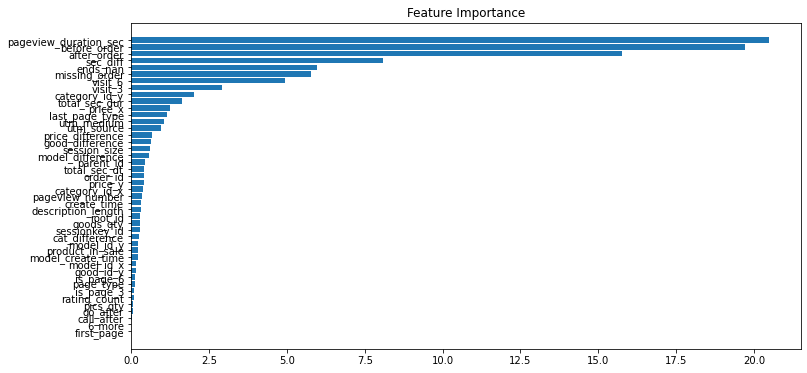

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

## THE END

In [ ]:
test_pred = model.predict_proba(X_test)[:, 1]
len(test_pred)

17196

In [ ]:
X_test['is_callcenter'] = test_pred
X_test['order_id'] = test_merge.order_id.values

In [ ]:
subm = X_test.loc[:, ('order_id', 'is_callcenter')]
subm.tail()

,order_id,is_callcenter
17191,1358397,0.075178
17192,1357968,0.012290
17193,1358835,0.977779
17194,1365692,0.083663
17195,1365429,0.003683


In [ ]:
subm.to_csv('gridsearch.csv', index=False)